24 Oct 2025

In [31]:
#basic_operations
import os
import math

#exploratory_data_analysis
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

#data_generation 
from scipy.interpolate import splprep, splev

#deep_learning
import torch
import torch.nn as nn
from complexPyTorch.complexLayers import ComplexLinear, ComplexReLU
from torch.utils.data import TensorDataset, DataLoader, random_split

#gpu_usage
from torch.nn.parallel import DistributedDataParallel as DDP
import torch.distributed as dist

#data_saving
import pickle as pkl

In [2]:
# Check if CUDA is available
print("Is CUDA available?", torch.cuda.is_available())

# Total number of GPUs available
num_gpus = torch.cuda.device_count()
print(f"Number of GPUs available: {num_gpus}")

# List all GPU names
for i in range(num_gpus):
    print(f"GPU {i}: {torch.cuda.get_device_name(i)}")


Is CUDA available? True
Number of GPUs available: 8
GPU 0: NVIDIA H100 80GB HBM3
GPU 1: NVIDIA H100 80GB HBM3
GPU 2: NVIDIA H100 80GB HBM3
GPU 3: NVIDIA H100 80GB HBM3
GPU 4: NVIDIA H100 80GB HBM3
GPU 5: NVIDIA H100 80GB HBM3
GPU 6: NVIDIA H100 80GB HBM3
GPU 7: NVIDIA H100 80GB HBM3


In [3]:
# Environment Parameters
epsilon = 1e-10
seed = 42


grid_min, grid_max = 0, 1
step_size = 0.1 # epsilon # distance after which angle changes.
total_time = 10
lookahead = 2
velocity = np.random.uniform(1, 5)
total_distance = velocity * total_time
num_steps = np.floor(total_distance / step_size)
rng = np.random.default_rng()

#x_initial, y_initial = np.random.uniform(grid_min, grid_max, size=2)
#head_dir_initial = math.radians(30)
#print(x_initial, y_initial)

tier_1 = np.arange(-30, 30, 1)
tier_2 = list(range(-60, -30)) + list(range(30, 60))
tier_3 = list(range(-90, -60)) + list(range(60, 90))
num_tries = 10


In [4]:
def get_future_pos(x_current, y_current, head_dir_current):
  x_future = x_current + lookahead * step_size * math.cos(head_dir_current)
  y_future = y_current + lookahead * step_size * math.sin(head_dir_current)
  return x_future, y_future

In [5]:
# Tiered search (random within tiers)
def wrap_angle(angle):
    return (angle + np.pi) % (2 * np.pi) - np.pi


def choose_head_dir(x_current, y_current, head_dir_current):
  for _ in range(num_tries):
    head_dir_next = wrap_angle(head_dir_current + math.radians(np.random.choice(tier_1)))
    x_future, y_future = get_future_pos(x_current, y_current, head_dir_next)
    if grid_min < x_future < grid_max and grid_min < y_future < grid_max:
      #print("Turning slightly")
      return x_future, y_future, head_dir_next

  for _ in range(num_tries):  
    head_dir_next = wrap_angle(head_dir_current + math.radians(np.random.choice(tier_2)))    
    x_future, y_future = get_future_pos(x_current, y_current, head_dir_next)
    if grid_min < x_future < grid_max and grid_min < y_future < grid_max:
      #print("Turning diagonally")
      return x_future, y_future, head_dir_next
  
  for _ in range(num_tries):
    head_dir_next = wrap_angle(head_dir_current + math.radians(np.random.choice(tier_3)))
    x_future, y_future = get_future_pos(x_current, y_current, head_dir_next)
    if grid_min <= x_future <= grid_max and grid_min < y_future < grid_max:
      #print("Turning almost orthagonally")
      return x_future, y_future, head_dir_next
    
  head_dir_next = wrap_angle(head_dir_current + math.radians(180))
  x_future, y_future = get_future_pos(x_current, y_current, head_dir_next)
  #print("Taking a U-turn")
  return x_future, y_future, head_dir_next

In [6]:
# Trajectory generation

def generate_trajectory(velocity):
    x_sharp = []
    y_sharp = []
    head_dir = []
    x_initial, y_initial = np.random.uniform(grid_min, grid_max, size=2)
    initial_positions = (x_initial, y_initial)
    head_dir_initial = math.radians(0)
    distance = velocity * total_time
    num_steps = np.floor(distance / step_size)

    for i in range(int(num_steps)):
        if i == 0:
            head_dir_current = head_dir_initial
            x_current, y_current = x_initial, y_initial
            x_sharp.append(x_current)
            y_sharp.append(y_current)
            head_dir.append(head_dir_current)
        
        x_future, y_future, head_dir_next = choose_head_dir(x_current, y_current, head_dir_current)
        x_next = x_current + step_size * math.cos(head_dir_next)
        y_next = y_current + step_size * math.sin(head_dir_next)
        
        head_dir_current = head_dir_next
        x_current, y_current = x_next, y_next

        x_sharp.append(x_current)
        y_sharp.append(y_current)
        head_dir.append(head_dir_current)


    x_sharp = np.array(x_sharp)
    y_sharp = np.array(y_sharp)
    head_dir = np.array(head_dir)
    initial_positions = np.array(initial_positions)
    #print(X.shape, Y.shape, HD.shape, initial_positions.shape)    
    return initial_positions, x_sharp, y_sharp    


In [7]:
# Using Spline function
def generate_smooth_trajectory(velocity):

    initial_positions, x_sharp, y_sharp = generate_trajectory(velocity)
    # s = smoothing factor, larger = smoother
    tck, u = splprep([x_sharp, y_sharp], s=0)
    u_new = np.linspace(0, 1, 1000)  # denser sampling
    x_smooth, y_smooth = splev(u_new, tck)
    return initial_positions, x_smooth, y_smooth

In [8]:
def compute_heading_vectors(x_smooth, y_smooth):
    cos_thetas, sin_thetas = [], []
    for i in range(len(x_smooth)-1):
        dx = x_smooth[i+1] - x_smooth[i]
        dy = y_smooth[i+1] - y_smooth[i]
        #heading_angle = math.atan2(dy, dx)
        norm = np.sqrt(dx**2 + dy**2) + 1e-8
        cos_theta = dx / norm
        sin_theta = dy / norm
        cos_thetas.append(cos_theta)
        sin_thetas.append(sin_theta)
    cos_thetas.append(cos_thetas[-1])  # Repeat last vector to maintain length
    sin_thetas.append(sin_thetas[-1])  # Repeat last vector to maintain length
    return cos_thetas, sin_thetas

In [9]:
def compute_abs_heading_vectors(x_smooth, y_smooth):
    cos_thetas, sin_thetas = [], []
    for i in range(len(x_smooth)):
        norm = np.sqrt(x_smooth[i]**2 + y_smooth[i]**2) + 1e-8
        cos_theta = x_smooth[i] / norm
        sin_theta = y_smooth[i] / norm
        cos_thetas.append(cos_theta)
        sin_thetas.append(sin_theta)
    return cos_thetas, sin_thetas

In [10]:
# Limb oscillations with curvature

#Parameters

dt = 0.01 # time step
time_series = np.arange(0, total_time, dt)
total_time_steps = len(time_series)

am = 0.1 # stride length
L = 0.05 # length of limb
phi = math.pi #phase difference between contralateral limbs
d = 0.05 # spacing between limb pairs

theta_m = am / (4 * L) # max angle of limb movement
limb_osc_freq = rng.uniform(1, 5) # frequency of limb oscillation
omega = 2 * math.pi * limb_osc_freq # angular frequency

def curvature(x, y):
    dx = np.gradient(x)
    dy = np.gradient(y)
    ddx = np.gradient(dx)
    ddy = np.gradient(dy)
    return (dx * ddy - dy * ddx) / ((dx**2 + dy**2)**1.5 + 1e-8)
    # To avoid division by zero

def limb_oscillations_with_curvature(t, am, L, omega, phi, d, x, y):
    theta_m = am / (4 * L)
    k = curvature(x, y)

    UFL = theta_m * (1 + k*d) * np.sin(omega*t)
    UFR = theta_m * (1 - k*d) * np.sin(omega*t + phi)
    UHR = theta_m * (1 - k*d) * np.sin(omega*t)
    UHL = theta_m * (1 + k*d) * np.sin(omega*t + phi)

    return UFL, UFR, UHR, UHL, k

In [11]:
# Generate 100 trajectories and corresponding limb oscillations

def generate_data(num_trajectories):
    x_smooth_all, y_smooth_all = [], []
    limb_data_all = []
    initial_positions_all = []
    cos_thetas_all, sin_thetas_all = [], []

    for trajectory in range(num_trajectories):
        limb_osc_freq = np.random.uniform(1, 5)
        velocity = am * limb_osc_freq
        omega = 2 * math.pi * limb_osc_freq #angular frequency
        
        initial_positions, x_smooth, y_smooth = generate_smooth_trajectory(velocity)
        cos_thetas, sin_thetas = compute_abs_heading_vectors(x_smooth, y_smooth)
        limb_data = limb_oscillations_with_curvature(time_series, am, L, omega, phi, d, x_smooth, y_smooth)
        
        initial_positions_all.append(initial_positions)
        x_smooth_all.append(x_smooth)
        y_smooth_all.append(y_smooth)
        cos_thetas_all.append(cos_thetas)
        sin_thetas_all.append(sin_thetas)
        limb_data_all.append(limb_data)


    return initial_positions_all, x_smooth_all, y_smooth_all, cos_thetas_all, sin_thetas_all, limb_data_all
    print("Generated", num_trajectories, "trajectories with corresponding limb oscillations.")

initial_positions_all, x_smooth_all, y_smooth_all, cos_thetas_all, sin_thetas_all, limb_data_all = generate_data(100)


In [12]:
initial_positions_all = np.array(initial_positions_all)
x_smooth_all = np.array(x_smooth_all)
y_smooth_all = np.array(y_smooth_all)
limb_data_all = np.array(limb_data_all)
cos_thetas_all = np.array(cos_thetas_all)
sin_thetas_all = np.array(sin_thetas_all)

print(initial_positions_all.shape, x_smooth_all.shape, y_smooth_all.shape, cos_thetas_all.shape, sin_thetas_all.shape, limb_data_all.shape)

(100, 2) (100, 1000) (100, 1000) (100, 1000) (100, 1000) (100, 5, 1000)


In [ ]:
traj_data = np.stack((x_smooth_all, y_smooth_all, cos_thetas_all, sin_thetas_all), axis=-1)
traj_data = np.array(traj_data)
print(traj_data.shape) # (100, 1000, 2)

gait_data = limb_data_all.transpose(0, 2, 1)  # (num_trajectories, time_steps, 4 limbs + curvature)
print(gait_data.shape) # (100, 1000, 5)
gait_data_without_curvature = gait_data[:, :, :4]
print(gait_data_without_curvature.shape) #(100, 1000, 4)

initial_positions_all_expanded = np.repeat(initial_positions_all[:, :, np.newaxis], 1000, axis=2)
print(initial_positions_all_expanded.shape)  # (100, 2, 1000)
initial_positions_transpose = initial_positions_all_expanded.transpose(0, 2, 1)
print(initial_positions_transpose.shape)  # (100, 1000, 2)

gait_data_with_initial_pos = np.concatenate((initial_positions_transpose, gait_data_without_curvature), axis=2)
print(gait_data_with_initial_pos.shape) # (100, 1000, 6)

(100, 1000, 4)
(100, 1000, 5)
(100, 1000, 4)
(100, 2, 1000)
(100, 1000, 2)
(100, 1000, 6)


In [14]:
X = gait_data_with_initial_pos
Y = {'pos': traj_data[:, :, :2], 'hd': traj_data[:, :, 2:]}

print(X.shape, len(Y), Y['pos'].shape, Y['hd'].shape)

(100, 1000, 6) 2 (100, 1000, 2) (100, 1000, 2)


In [32]:
# Saving trajectory data
traj_index = 50
model = '2d_no_rest'

traj_50_data = Y['pos'][traj_index]
x_traj = traj_data[:, 0]
y_traj = traj_data[:, 1]


trajectory_data = {'x': x_traj, 'y': y_traj}
with open(f'0_trajectory_data/trajectory_data_{model}_{traj_index}.pkl', 'wb') as f:
    pkl.dump(trajectory_data, f)

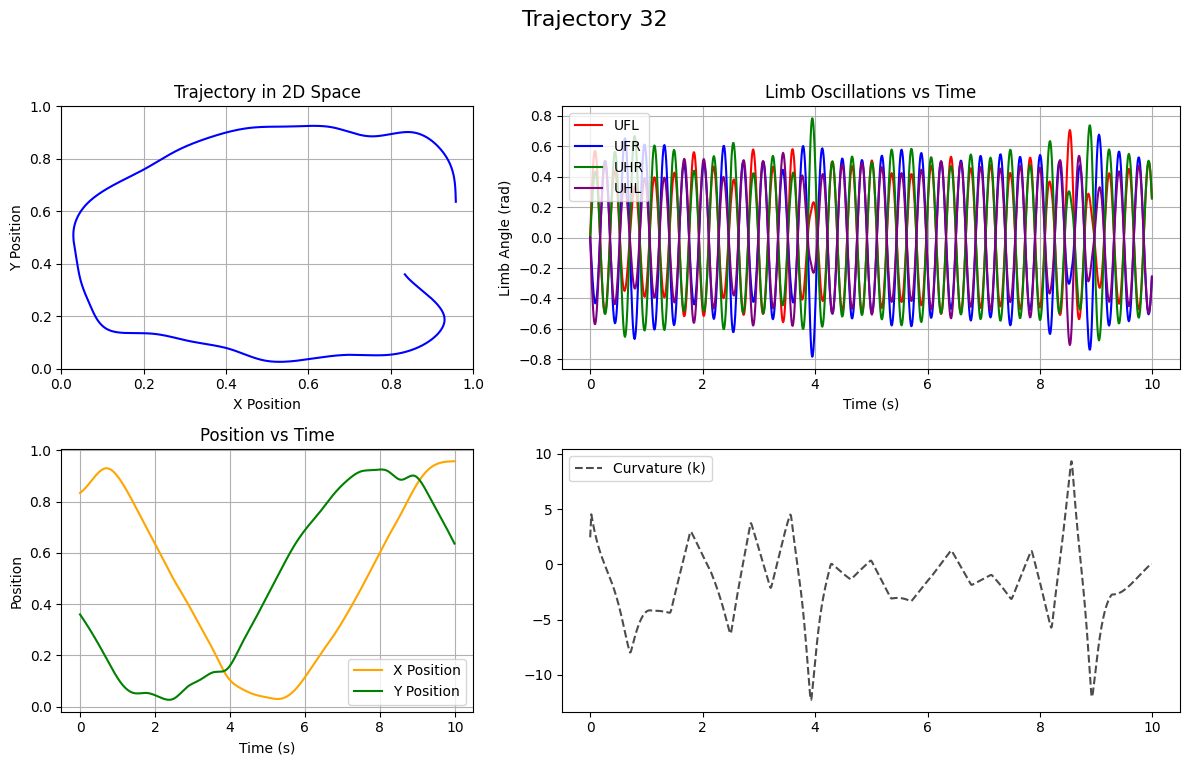

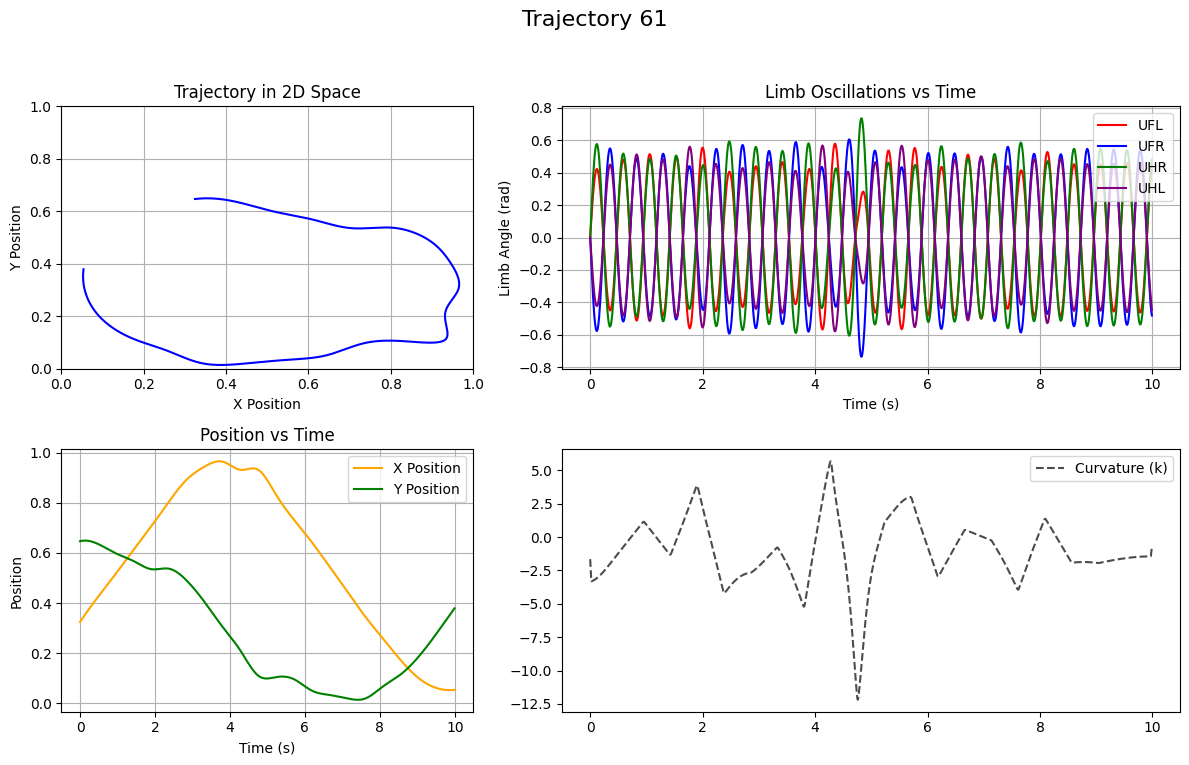

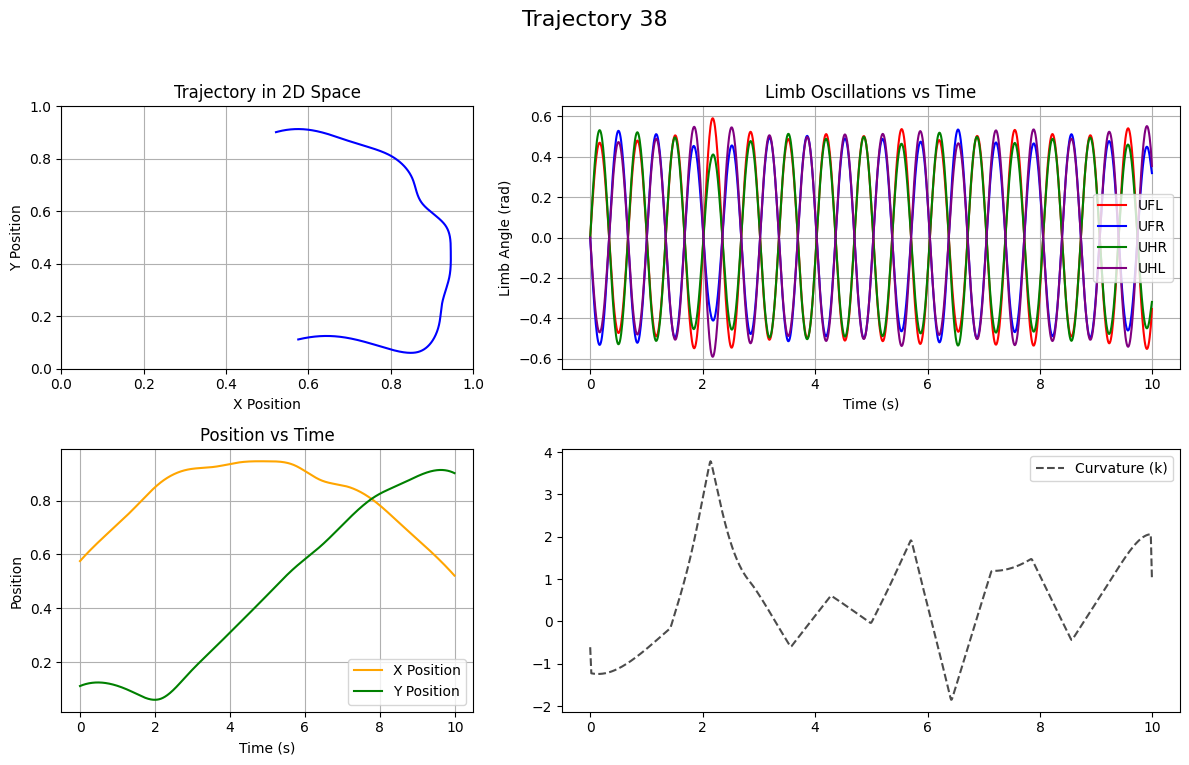

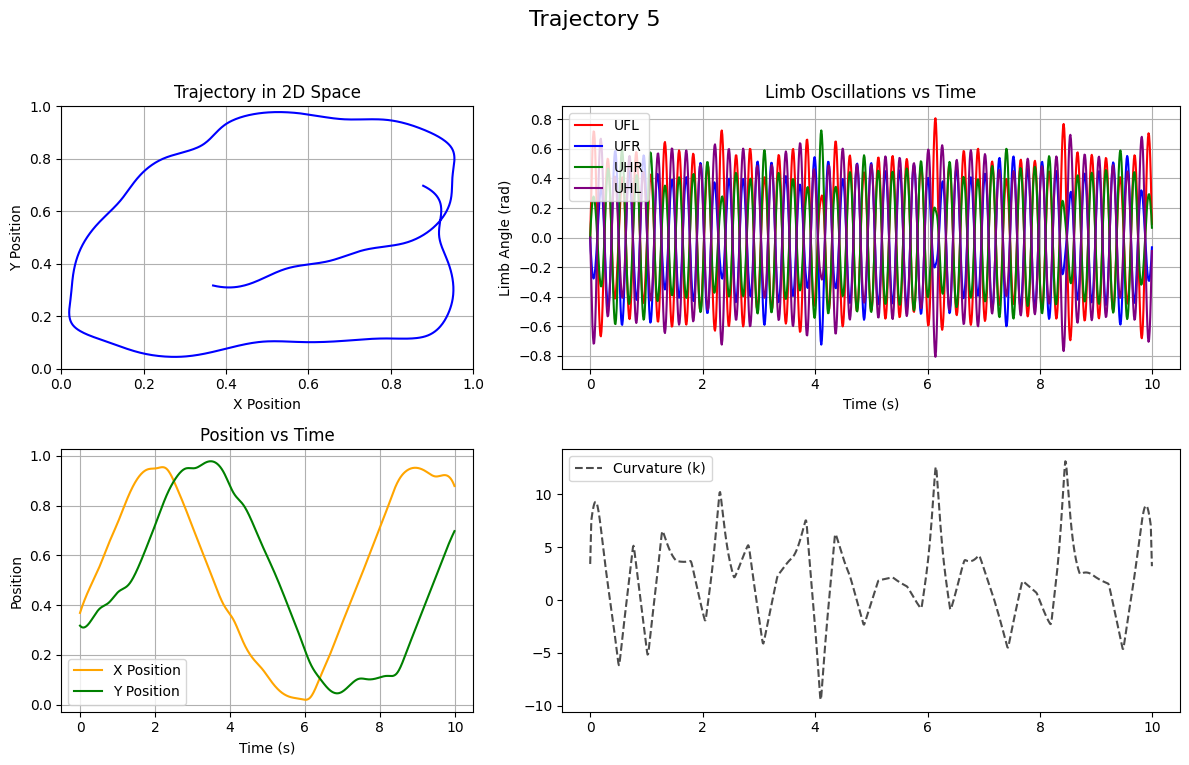

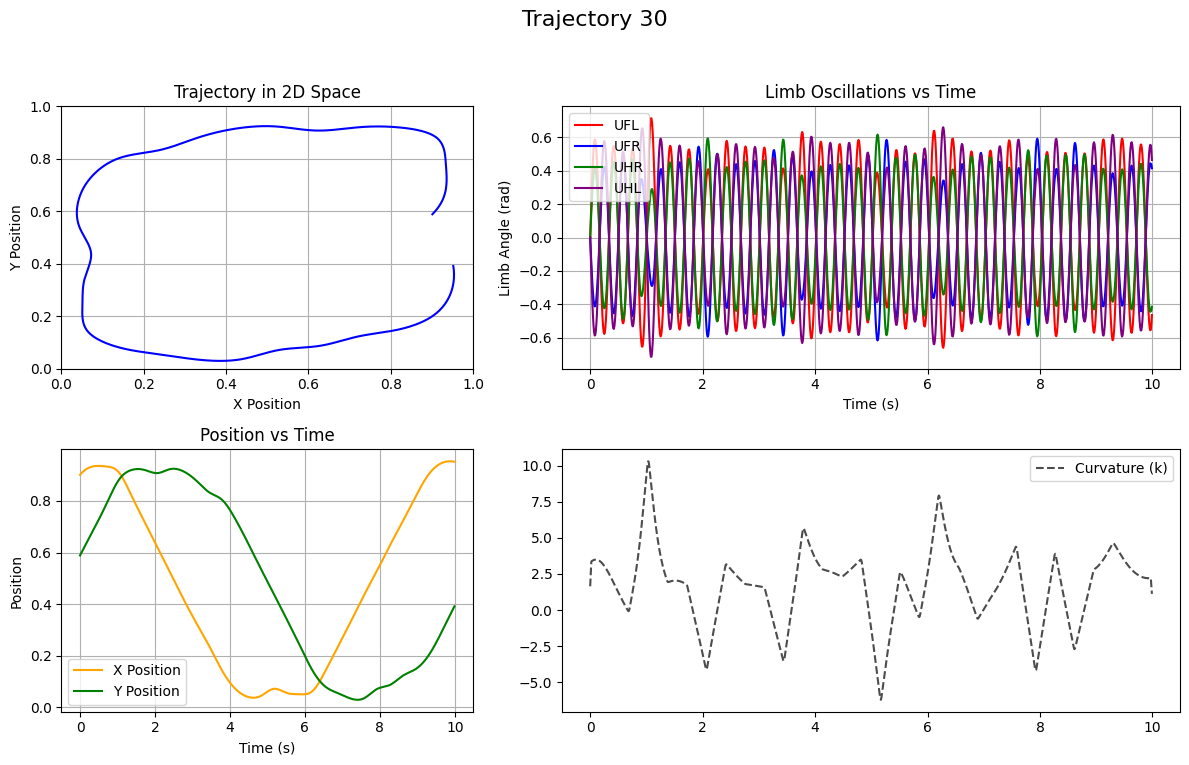

In [33]:
# Plotting trajectory, position vs time and limb oscillations for five random trajectories
for i in range(5):
    traj_index = np.random.randint(0, 100)
    traj_data = Y['pos'][traj_index]
    x_traj = traj_data[:, 0]
    y_traj = traj_data[:, 1]
    limb_data_traj = limb_data_all[traj_index, :, :]
    UFL_traj, UFR_traj, UHR_traj, UHL_traj, k_traj = limb_data_traj

    # Time vector
    t = time_series[:len(x_traj)]

    # Create a 2x2 grid
    fig, axes = plt.subplots(2, 2, figsize=(12, 8), gridspec_kw={'width_ratios': [1, 1.5]})
    fig.suptitle(f"Trajectory {traj_index+1}", fontsize=16)

    # --- Top-left: Trajectory in grid ---
    axes[0, 0].plot(x_traj, y_traj, color='blue')
    axes[0, 0].set_title('Trajectory in 2D Space')
    axes[0, 0].set_xlabel('X Position')
    axes[0, 0].set_ylabel('Y Position')
    axes[0, 0].set_xlim(0, 1)
    axes[0, 0].set_ylim(0, 1)
    axes[0, 0].grid()

    # --- Bottom-left: Position vs time ---
    axes[1, 0].plot(t, x_traj, label='X Position', color='orange')
    axes[1, 0].plot(t, y_traj, label='Y Position', color='green')
    #axes[1, 0].plot(t, head_direction_traj[:len(t)], label='Head Direction', color='purple', linestyle='--', alpha=0.7)
    axes[1, 0].set_title('Position vs Time')
    axes[1, 0].set_xlabel('Time (s)')
    axes[1, 0].set_ylabel('Position')
    axes[1, 0].legend()
    axes[1, 0].grid()

    # --- Right column (span): Limb oscillations ---
    ax_right = axes[0, 1]
    #axes[1, 1].remove()  # merge bottom cell with top
    ax_right.plot(t, UFL_traj[:len(t)], label='UFL', color='red')
    ax_right.plot(t, UFR_traj[:len(t)], label='UFR', color='blue')
    ax_right.plot(t, UHR_traj[:len(t)], label='UHR', color='green')
    ax_right.plot(t, UHL_traj[:len(t)], label='UHL', color='purple')
    ax_right.set_title('Limb Oscillations vs Time')
    ax_right.set_xlabel('Time (s)')
    ax_right.set_ylabel('Limb Angle (rad)')
    ax_right.legend()
    ax_right.grid()

    #Plotting k values
    ax_bottom_right = axes[1, 1]
    
    ax_bottom_right.plot(t, k_traj[:len(t)], label='Curvature (k)', color='black', linestyle='--', alpha=0.7)
    #ax_bottom_right.set_ylim(-30, 30)
    ax_bottom_right.legend()
    #ax_bottom_right.set_ylabel('Curvature (k)')
    #ax_k.legend(loc='upper right')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


In [34]:
#Hopf Oscillator

def real_cal(r, phi):
    return r * torch.cos(phi)

def imag_cal(r, phi):
    return r * torch.sin(phi)


def oscillator_loop(X_r, X_i, omegas, num_steps, dt=0.01, input_scaler=10.0):
    
    """
    X_r, X_i: real and imaginary parts of input signal [batch, time, units]
    omegas: angular frequencies of oscillators [1, units]
    num_steps: number of time steps
    """

    batch_size, _, units = X_r.shape
    

    # amplitude and phase initialisation
    r_t = torch.ones((batch_size, units), device=X_r.device)
    #phis = torch.zeros((batch_size, units), device=X_r.device)

    #r_t = 0.9 + 0.2 * torch.rand((batch_size, units), device=X_r.device)
    phis = (2 * math.pi) * torch.rand((batch_size, units), device=X_r.device) - math.pi

    r_list, phi_list = [], []

    for t in range(num_steps):
        # input at current time step
        input_r = input_scaler * X_r[:, t, :] * torch.cos(phis)
        input_phi = input_scaler * X_i[:, t, :] * torch.sin(phis)

        # Hopf oscillator update equations
        r_t = r_t + ((1 - r_t**2) * r_t + input_r) * dt
        phis = phis + (omegas - input_phi) * dt

        r_list.append(r_t.unsqueeze(1))   # keep time dimension
        phi_list.append(phis.unsqueeze(1))

    # Stack time axis -> shape [batch, time, units]
    r_arr = torch.cat(r_list, dim=1)
    phi_arr = torch.cat(phi_list, dim=1)
    return r_arr, phi_arr



class Hopf(nn.Module):
    def __init__(self, units, num_steps, min_f=0.1, max_f=10.1):
        super(Hopf, self).__init__()
        self.units = units
        self.num_steps = num_steps

        # Frequencies equally spaced between min_f and max_f
        omegas = torch.linspace(min_f, max_f, units) * (2 * math.pi)
        self.register_buffer('omegas', omegas.unsqueeze(0))  # [1, units]

    def forward(self, z_complex):
        """
        z_complex: complex input tensor [batch, time, units]
        """
        X_r = z_complex.real
        X_i = z_complex.imag

        r, phi = oscillator_loop(X_r, X_i, self.omegas, self.num_steps)

        z_real = real_cal(r, phi)
        z_imag = imag_cal(r, phi)
        return torch.complex(z_real, z_imag)


In [35]:

class DONN(nn.Module):
    def __init__(self, units, duration):
        super(DONN, self).__init__()

        # -----------------------------
        # Complex Dense + Hopf layers
        # -----------------------------
        self.d1 = nn.Sequential(
            ComplexLinear(X.shape[-1], units),
            ComplexReLU()
        )
        self.osc1 = Hopf(units, num_steps=duration, min_f=1, max_f=5)

        self.d2 = nn.Sequential(
            ComplexLinear(units, units),
            ComplexReLU()
        )
        self.osc2 = Hopf(units, num_steps=duration, min_f=4, max_f=8)

        self.d3 = nn.Sequential(
            ComplexLinear(units, units),
            ComplexReLU()
        )
        self.osc3 = Hopf(units, num_steps=duration, min_f=8, max_f=10)

        self.d4 = nn.Sequential(
            ComplexLinear(units, units),
            ComplexReLU()
        )

        # -----------------------------
        # Real-valued output heads
        # -----------------------------
        self.pos_out = nn.Sequential(
            nn.Linear(units * 2, 2),  # for (x, y)
            nn.Sigmoid()
        )

        self.hd_out = nn.Sequential(
            nn.Linear(units * 2, 2),  # for (cosθ, sinθ)
            nn.Tanh()
        )

    def forward(self, X):
        """
        X: [batch, time, units] real input signal
        """

        # Convert to complex
        X_c = torch.complex(X, torch.zeros_like(X))

        # Sequential complex transformations + Hopf oscillations
        d1 = self.d1(X_c)
        z1 = self.osc1(d1)

        d2 = self.d2(z1)
        z2 = self.osc2(d2)

        d3 = self.d3(z2)
        z3 = self.osc3(d3)

        d4 = self.d4(z3)

        # Concatenate real + imag for output layers
        d4_concat = torch.cat([d4.real, d4.imag], dim=-1)

        # Position output (sigmoid) → (x, y)
        pos_out = self.pos_out(d4_concat)

        # Head direction output (tanh) → (cosθ, sinθ)
        hd_out = self.hd_out(d4_concat)
        hd_norm = hd_out / (torch.norm(hd_out, dim=-1, keepdim=True) + 1e-8)

        return {"pos": pos_out, "hd": hd_norm}


In [36]:

def custom_hd_loss(hd_pred, hd_true, alpha=1.0, beta=0.5):
    """
    Custom head-direction loss combining cosine similarity + circular penalty.
    """
    # Normalize both true and predicted vectors
    hd_true = hd_true / (torch.norm(hd_true, dim=-1, keepdim=True) + 1e-8)
    hd_pred = hd_pred / (torch.norm(hd_pred, dim=-1, keepdim=True) + 1e-8)

    # Cosine similarity loss
    cos_sim = torch.sum(hd_true * hd_pred, dim=-1)
    cos_sim_loss = 1.0 - torch.mean(cos_sim)

    # Circle penalty: (cos^2 + sin^2 - 1)^2
    circle_loss = torch.mean((torch.sum(hd_pred ** 2, dim=-1) - 1.0) ** 2)

    return alpha * cos_sim_loss + beta * circle_loss


In [37]:

# Hyperparameters
units = 100
learning_rate = 0.001
batch_size = 50
epochs = 300

duration = total_time_steps  # same as in TF version

# Initialize model
model = DONN(units=units, duration=duration)

# ========================GPU Usage========================
# Template:
'''
Instantiate the model
Define primary device
Move model to primary device
Wrap things like DataParallel or DDP if needed
'''

# To use any GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

#To use a specific GPU
#device = torch.device("cuda:4")
#model.to(device)

# To use all GPUs in parallel
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# model = model.to(device)
# if torch.cuda.device_count() > 1:
#     print("Using", torch.cuda.device_count(), "GPUs")
#     model = nn.DataParallel(model)

# To use a specific SET of GPUs
# device_ids = [1, 2, 3]
# device = torch.device(f'cuda:{device_ids[0]}')
# model = model.to(f'cuda:{device_ids[0]}')
# model = nn.DataParallel(model, device_ids=device_ids)

# Distributed Data Parallel (DDP)
# For large processes
# Code modularization needed for this

#Print the GPUs being used
print("Model is running on:", next(model.parameters()).device)

# ========================GPU Usage========================

# Optimizer and loss functions
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
mse_loss = nn.MSELoss()


Model is running on: cuda:0


In [38]:
# Convert NumPy arrays to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
Y_pos_tensor = torch.tensor(Y["pos"], dtype=torch.float32)
Y_hd_tensor = torch.tensor(Y["hd"], dtype=torch.float32)

# Combine into one dataset
dataset = TensorDataset(X_tensor, Y_pos_tensor, Y_hd_tensor)

# 80-20 train-validation split
val_size = int(0.2 * len(dataset))
train_size = len(dataset) - val_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)


In [39]:
more_epochs = 200

for epoch in range(epochs):
    model.train()
    total_loss = 0.0
    
    batch_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False)
    
    for X_batch, Y_pos_batch, Y_hd_batch in batch_bar:
        X_batch, Y_pos_batch, Y_hd_batch = X_batch.to(device), Y_pos_batch.to(device), Y_hd_batch.to(device)

        optimizer.zero_grad()

        outputs = model(X_batch)
        pos_pred = outputs["pos"]
        hd_pred = outputs["hd"]

        # Compute combined loss
        loss_pos = mse_loss(pos_pred, Y_pos_batch)
        loss_hd = custom_hd_loss(hd_pred, Y_hd_batch)
        #loss_hd = mse_loss(hd_pred, Y_hd_batch)
        loss = loss_pos + loss_hd
        

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    # Validation
    model.eval()
    with torch.no_grad():
        val_loss = 0.0
        for X_val, Y_pos_val, Y_hd_val in val_loader:
            X_val, Y_pos_val, Y_hd_val = X_val.to(device), Y_pos_val.to(device), Y_hd_val.to(device)
            outputs = model(X_val)
            pos_pred = outputs["pos"]
            hd_pred = outputs["hd"]
            val_loss += (mse_loss(pos_pred, Y_pos_val) + custom_hd_loss(Y_hd_val, hd_pred)).item()

    tqdm.write(f"Epoch [{epoch+1}/{epochs}] | Train Loss: {total_loss/len(train_loader):.6f} | Val Loss: {val_loss/len(val_loader):.6f}")


Epoch [1/300] | Train Loss: 1.280898 | Val Loss: 1.004458


Epoch [2/300] | Train Loss: 0.877747 | Val Loss: 0.672971


Epoch [3/300] | Train Loss: 0.584095 | Val Loss: 0.475203


Epoch [4/300] | Train Loss: 0.407507 | Val Loss: 0.359595


Epoch [5/300] | Train Loss: 0.313250 | Val Loss: 0.292433


Epoch [6/300] | Train Loss: 0.261740 | Val Loss: 0.256520


Epoch [7/300] | Train Loss: 0.233819 | Val Loss: 0.232541


Epoch [8/300] | Train Loss: 0.216525 | Val Loss: 0.222468


Epoch [9/300] | Train Loss: 0.205226 | Val Loss: 0.211756


Epoch [10/300] | Train Loss: 0.198956 | Val Loss: 0.210292


Epoch [11/300] | Train Loss: 0.195521 | Val Loss: 0.204832


Epoch [12/300] | Train Loss: 0.192095 | Val Loss: 0.202887


Epoch [13/300] | Train Loss: 0.192909 | Val Loss: 0.203098


Epoch [14/300] | Train Loss: 0.192167 | Val Loss: 0.201631


Epoch [15/300] | Train Loss: 0.191370 | Val Loss: 0.200341


Epoch [16/300] | Train Loss: 0.191113 | Val Loss: 0.199328


Epoch [17/300] | Train Loss: 0.190346 | Val Loss: 0.196360


Epoch [18/300] | Train Loss: 0.191547 | Val Loss: 0.198258


Epoch [19/300] | Train Loss: 0.190772 | Val Loss: 0.198095


Epoch [20/300] | Train Loss: 0.190599 | Val Loss: 0.198017


Epoch [21/300] | Train Loss: 0.190092 | Val Loss: 0.197333


Epoch [22/300] | Train Loss: 0.189211 | Val Loss: 0.197006


Epoch [23/300] | Train Loss: 0.187880 | Val Loss: 0.195866


Epoch [24/300] | Train Loss: 0.189212 | Val Loss: 0.197044


Epoch [25/300] | Train Loss: 0.190145 | Val Loss: 0.196395


Epoch [26/300] | Train Loss: 0.188186 | Val Loss: 0.195894


Epoch [27/300] | Train Loss: 0.188489 | Val Loss: 0.196656


Epoch [28/300] | Train Loss: 0.188494 | Val Loss: 0.195985


Epoch [29/300] | Train Loss: 0.186835 | Val Loss: 0.195756


Epoch [30/300] | Train Loss: 0.190634 | Val Loss: 0.196022


Epoch [31/300] | Train Loss: 0.188465 | Val Loss: 0.196214


Epoch [32/300] | Train Loss: 0.187443 | Val Loss: 0.195195


Epoch [33/300] | Train Loss: 0.189328 | Val Loss: 0.196202


Epoch [34/300] | Train Loss: 0.187329 | Val Loss: 0.196956


Epoch [35/300] | Train Loss: 0.188485 | Val Loss: 0.196578


Epoch [36/300] | Train Loss: 0.186611 | Val Loss: 0.196726


Epoch [37/300] | Train Loss: 0.189805 | Val Loss: 0.195938


Epoch [38/300] | Train Loss: 0.186929 | Val Loss: 0.195458


Epoch [39/300] | Train Loss: 0.187852 | Val Loss: 0.195221


Epoch [40/300] | Train Loss: 0.188187 | Val Loss: 0.195846


Epoch [41/300] | Train Loss: 0.187757 | Val Loss: 0.194697


Epoch [42/300] | Train Loss: 0.188661 | Val Loss: 0.196311


Epoch [43/300] | Train Loss: 0.186610 | Val Loss: 0.195705


Epoch [44/300] | Train Loss: 0.190794 | Val Loss: 0.197345


Epoch [45/300] | Train Loss: 0.187452 | Val Loss: 0.196049


Epoch [46/300] | Train Loss: 0.189754 | Val Loss: 0.194927


Epoch [47/300] | Train Loss: 0.185692 | Val Loss: 0.195031


Epoch [48/300] | Train Loss: 0.185861 | Val Loss: 0.196214


Epoch [49/300] | Train Loss: 0.187784 | Val Loss: 0.194410


Epoch [50/300] | Train Loss: 0.188173 | Val Loss: 0.196518


Epoch [51/300] | Train Loss: 0.188427 | Val Loss: 0.196048


Epoch [52/300] | Train Loss: 0.186941 | Val Loss: 0.195570


Epoch [53/300] | Train Loss: 0.186210 | Val Loss: 0.195279


Epoch [54/300] | Train Loss: 0.188259 | Val Loss: 0.196312


Epoch [55/300] | Train Loss: 0.186545 | Val Loss: 0.196833


Epoch [56/300] | Train Loss: 0.188797 | Val Loss: 0.197230


Epoch [57/300] | Train Loss: 0.187271 | Val Loss: 0.197657


Epoch [58/300] | Train Loss: 0.185644 | Val Loss: 0.194196


Epoch [59/300] | Train Loss: 0.186168 | Val Loss: 0.195502


Epoch [60/300] | Train Loss: 0.185758 | Val Loss: 0.194930


Epoch [61/300] | Train Loss: 0.187952 | Val Loss: 0.196237


Epoch [62/300] | Train Loss: 0.189180 | Val Loss: 0.194437


Epoch [63/300] | Train Loss: 0.188202 | Val Loss: 0.194321


Epoch [64/300] | Train Loss: 0.187669 | Val Loss: 0.196626


Epoch [65/300] | Train Loss: 0.186398 | Val Loss: 0.195077


Epoch [66/300] | Train Loss: 0.185718 | Val Loss: 0.195468


Epoch [67/300] | Train Loss: 0.188590 | Val Loss: 0.194642


Epoch [68/300] | Train Loss: 0.186153 | Val Loss: 0.195850


Epoch [69/300] | Train Loss: 0.189335 | Val Loss: 0.195069


Epoch [70/300] | Train Loss: 0.187909 | Val Loss: 0.196321


Epoch [71/300] | Train Loss: 0.187290 | Val Loss: 0.196048


Epoch [72/300] | Train Loss: 0.186446 | Val Loss: 0.196638


Epoch [73/300] | Train Loss: 0.185548 | Val Loss: 0.196478


Epoch [74/300] | Train Loss: 0.189067 | Val Loss: 0.195890


Epoch [75/300] | Train Loss: 0.184839 | Val Loss: 0.195373


Epoch [76/300] | Train Loss: 0.186419 | Val Loss: 0.195252


Epoch [77/300] | Train Loss: 0.187945 | Val Loss: 0.194749


Epoch [78/300] | Train Loss: 0.186106 | Val Loss: 0.196146


Epoch [79/300] | Train Loss: 0.186230 | Val Loss: 0.194768


Epoch [80/300] | Train Loss: 0.184394 | Val Loss: 0.195370


Epoch [81/300] | Train Loss: 0.184426 | Val Loss: 0.197061


Epoch [82/300] | Train Loss: 0.185999 | Val Loss: 0.195072


Epoch [83/300] | Train Loss: 0.187477 | Val Loss: 0.195071


Epoch [84/300] | Train Loss: 0.188057 | Val Loss: 0.194862


Epoch [85/300] | Train Loss: 0.186296 | Val Loss: 0.193795


Epoch [86/300] | Train Loss: 0.186199 | Val Loss: 0.194730


Epoch [87/300] | Train Loss: 0.187519 | Val Loss: 0.193100


Epoch [88/300] | Train Loss: 0.186184 | Val Loss: 0.194578


Epoch [89/300] | Train Loss: 0.188800 | Val Loss: 0.194425


Epoch [90/300] | Train Loss: 0.185814 | Val Loss: 0.195623


Epoch [91/300] | Train Loss: 0.187752 | Val Loss: 0.195282


Epoch [92/300] | Train Loss: 0.186720 | Val Loss: 0.196150


Epoch [93/300] | Train Loss: 0.187892 | Val Loss: 0.195284


Epoch [94/300] | Train Loss: 0.185678 | Val Loss: 0.195298


Epoch [95/300] | Train Loss: 0.186726 | Val Loss: 0.194335


Epoch [96/300] | Train Loss: 0.186175 | Val Loss: 0.194539


Epoch [97/300] | Train Loss: 0.186925 | Val Loss: 0.194181


Epoch [98/300] | Train Loss: 0.188089 | Val Loss: 0.194808


Epoch [99/300] | Train Loss: 0.188367 | Val Loss: 0.194596


Epoch [100/300] | Train Loss: 0.186269 | Val Loss: 0.195011


Epoch [101/300] | Train Loss: 0.187900 | Val Loss: 0.194436


Epoch [102/300] | Train Loss: 0.187788 | Val Loss: 0.195446


Epoch [103/300] | Train Loss: 0.186170 | Val Loss: 0.194770


Epoch [104/300] | Train Loss: 0.187020 | Val Loss: 0.195756


Epoch [105/300] | Train Loss: 0.188618 | Val Loss: 0.194210


Epoch [106/300] | Train Loss: 0.186256 | Val Loss: 0.196182


Epoch [107/300] | Train Loss: 0.185794 | Val Loss: 0.195817


Epoch [108/300] | Train Loss: 0.186758 | Val Loss: 0.196771


Epoch [109/300] | Train Loss: 0.187608 | Val Loss: 0.195314


Epoch [110/300] | Train Loss: 0.184927 | Val Loss: 0.195777


Epoch [111/300] | Train Loss: 0.185533 | Val Loss: 0.194952


Epoch [112/300] | Train Loss: 0.186795 | Val Loss: 0.195088


Epoch [113/300] | Train Loss: 0.186493 | Val Loss: 0.194541


Epoch [114/300] | Train Loss: 0.188952 | Val Loss: 0.194755


Epoch [115/300] | Train Loss: 0.185519 | Val Loss: 0.195143


Epoch [116/300] | Train Loss: 0.186607 | Val Loss: 0.195159


Epoch [117/300] | Train Loss: 0.186886 | Val Loss: 0.194227


Epoch [118/300] | Train Loss: 0.185312 | Val Loss: 0.195623


Epoch [119/300] | Train Loss: 0.186410 | Val Loss: 0.195793


Epoch [120/300] | Train Loss: 0.185746 | Val Loss: 0.194850


Epoch [121/300] | Train Loss: 0.186921 | Val Loss: 0.194762


Epoch [122/300] | Train Loss: 0.189750 | Val Loss: 0.195927


Epoch [123/300] | Train Loss: 0.184215 | Val Loss: 0.194383


Epoch [124/300] | Train Loss: 0.187623 | Val Loss: 0.194519


Epoch [125/300] | Train Loss: 0.187118 | Val Loss: 0.195677


Epoch [126/300] | Train Loss: 0.187276 | Val Loss: 0.193952


Epoch [127/300] | Train Loss: 0.186731 | Val Loss: 0.195649


Epoch [128/300] | Train Loss: 0.185077 | Val Loss: 0.193933


Epoch [129/300] | Train Loss: 0.188565 | Val Loss: 0.195064


Epoch [130/300] | Train Loss: 0.187461 | Val Loss: 0.195016


Epoch [131/300] | Train Loss: 0.186410 | Val Loss: 0.195242


Epoch [132/300] | Train Loss: 0.186555 | Val Loss: 0.194705


Epoch [133/300] | Train Loss: 0.187255 | Val Loss: 0.193925


Epoch [134/300] | Train Loss: 0.187779 | Val Loss: 0.194721


Epoch [135/300] | Train Loss: 0.185716 | Val Loss: 0.194295


Epoch [136/300] | Train Loss: 0.186071 | Val Loss: 0.194597


Epoch [137/300] | Train Loss: 0.186927 | Val Loss: 0.195592


Epoch [138/300] | Train Loss: 0.187050 | Val Loss: 0.195175


Epoch [139/300] | Train Loss: 0.186179 | Val Loss: 0.195153


Epoch [140/300] | Train Loss: 0.186398 | Val Loss: 0.194255


Epoch [141/300] | Train Loss: 0.185766 | Val Loss: 0.194325


Epoch [142/300] | Train Loss: 0.185757 | Val Loss: 0.195240


Epoch [143/300] | Train Loss: 0.187773 | Val Loss: 0.193967


Epoch [144/300] | Train Loss: 0.184547 | Val Loss: 0.194322


Epoch [145/300] | Train Loss: 0.187307 | Val Loss: 0.194842


Epoch [146/300] | Train Loss: 0.186728 | Val Loss: 0.194948


Epoch [147/300] | Train Loss: 0.186911 | Val Loss: 0.193922


Epoch [148/300] | Train Loss: 0.184830 | Val Loss: 0.195711


Epoch [149/300] | Train Loss: 0.183968 | Val Loss: 0.194583


Epoch [150/300] | Train Loss: 0.185388 | Val Loss: 0.194046


Epoch [151/300] | Train Loss: 0.185418 | Val Loss: 0.195421


Epoch [152/300] | Train Loss: 0.187483 | Val Loss: 0.195307


Epoch [153/300] | Train Loss: 0.188178 | Val Loss: 0.194276


Epoch [154/300] | Train Loss: 0.185374 | Val Loss: 0.194947


Epoch [155/300] | Train Loss: 0.185784 | Val Loss: 0.193863


Epoch [156/300] | Train Loss: 0.188255 | Val Loss: 0.194682


Epoch [157/300] | Train Loss: 0.187732 | Val Loss: 0.195068


Epoch [158/300] | Train Loss: 0.187570 | Val Loss: 0.194473


Epoch [159/300] | Train Loss: 0.186914 | Val Loss: 0.194238


Epoch [160/300] | Train Loss: 0.186056 | Val Loss: 0.195356


Epoch [161/300] | Train Loss: 0.186012 | Val Loss: 0.193854


Epoch [162/300] | Train Loss: 0.187381 | Val Loss: 0.193829


Epoch [163/300] | Train Loss: 0.186735 | Val Loss: 0.194360


Epoch [164/300] | Train Loss: 0.187638 | Val Loss: 0.194753


Epoch [165/300] | Train Loss: 0.184850 | Val Loss: 0.194673


Epoch [166/300] | Train Loss: 0.188745 | Val Loss: 0.195394


Epoch [167/300] | Train Loss: 0.186122 | Val Loss: 0.193954


Epoch [168/300] | Train Loss: 0.184171 | Val Loss: 0.194326


Epoch [169/300] | Train Loss: 0.185602 | Val Loss: 0.194165


Epoch [170/300] | Train Loss: 0.185617 | Val Loss: 0.194327


Epoch [171/300] | Train Loss: 0.186214 | Val Loss: 0.194262


Epoch [172/300] | Train Loss: 0.185098 | Val Loss: 0.194283


Epoch [173/300] | Train Loss: 0.185703 | Val Loss: 0.194085


Epoch [174/300] | Train Loss: 0.187051 | Val Loss: 0.193651


Epoch [175/300] | Train Loss: 0.186477 | Val Loss: 0.194193


Epoch [176/300] | Train Loss: 0.185725 | Val Loss: 0.193529


Epoch [177/300] | Train Loss: 0.188411 | Val Loss: 0.194001


Epoch [178/300] | Train Loss: 0.186674 | Val Loss: 0.193987


Epoch [179/300] | Train Loss: 0.185979 | Val Loss: 0.192950


Epoch [180/300] | Train Loss: 0.187377 | Val Loss: 0.194626


Epoch [181/300] | Train Loss: 0.186666 | Val Loss: 0.195478


Epoch [182/300] | Train Loss: 0.186822 | Val Loss: 0.194135


Epoch [183/300] | Train Loss: 0.187087 | Val Loss: 0.194864


Epoch [184/300] | Train Loss: 0.185363 | Val Loss: 0.194269


Epoch [185/300] | Train Loss: 0.187384 | Val Loss: 0.195054


Epoch [186/300] | Train Loss: 0.188068 | Val Loss: 0.194344


Epoch [187/300] | Train Loss: 0.187497 | Val Loss: 0.193471


Epoch [188/300] | Train Loss: 0.186079 | Val Loss: 0.193626


Epoch [189/300] | Train Loss: 0.185845 | Val Loss: 0.193840


Epoch [190/300] | Train Loss: 0.186584 | Val Loss: 0.194044


Epoch [191/300] | Train Loss: 0.185517 | Val Loss: 0.193863


Epoch [192/300] | Train Loss: 0.184858 | Val Loss: 0.193864


Epoch [193/300] | Train Loss: 0.185637 | Val Loss: 0.194791


Epoch [194/300] | Train Loss: 0.186558 | Val Loss: 0.194862


Epoch [195/300] | Train Loss: 0.188680 | Val Loss: 0.195095


Epoch [196/300] | Train Loss: 0.188086 | Val Loss: 0.193481


Epoch [197/300] | Train Loss: 0.186121 | Val Loss: 0.194191


Epoch [198/300] | Train Loss: 0.186473 | Val Loss: 0.194782


Epoch [199/300] | Train Loss: 0.187131 | Val Loss: 0.194237


Epoch [200/300] | Train Loss: 0.186878 | Val Loss: 0.194421


Epoch [201/300] | Train Loss: 0.186076 | Val Loss: 0.194100


Epoch [202/300] | Train Loss: 0.186837 | Val Loss: 0.194513


Epoch [203/300] | Train Loss: 0.184275 | Val Loss: 0.194876


Epoch [204/300] | Train Loss: 0.185823 | Val Loss: 0.193745


Epoch [205/300] | Train Loss: 0.186083 | Val Loss: 0.194299


Epoch [206/300] | Train Loss: 0.185404 | Val Loss: 0.193644


Epoch [207/300] | Train Loss: 0.187315 | Val Loss: 0.194645


Epoch [208/300] | Train Loss: 0.186997 | Val Loss: 0.193954


Epoch [209/300] | Train Loss: 0.187753 | Val Loss: 0.194364


Epoch [210/300] | Train Loss: 0.186304 | Val Loss: 0.193630


Epoch [211/300] | Train Loss: 0.187902 | Val Loss: 0.195219


Epoch [212/300] | Train Loss: 0.185847 | Val Loss: 0.195612


Epoch [213/300] | Train Loss: 0.185608 | Val Loss: 0.194441


Epoch [214/300] | Train Loss: 0.186495 | Val Loss: 0.195729


Epoch [215/300] | Train Loss: 0.187565 | Val Loss: 0.193586


Epoch [216/300] | Train Loss: 0.185002 | Val Loss: 0.193780


Epoch [217/300] | Train Loss: 0.188036 | Val Loss: 0.194505


Epoch [218/300] | Train Loss: 0.186830 | Val Loss: 0.195326


Epoch [219/300] | Train Loss: 0.186233 | Val Loss: 0.194222


Epoch [220/300] | Train Loss: 0.185054 | Val Loss: 0.194943


Epoch [221/300] | Train Loss: 0.186454 | Val Loss: 0.194228


Epoch [222/300] | Train Loss: 0.184697 | Val Loss: 0.194266


Epoch [223/300] | Train Loss: 0.188087 | Val Loss: 0.195204


Epoch [224/300] | Train Loss: 0.186752 | Val Loss: 0.193447


Epoch [225/300] | Train Loss: 0.183848 | Val Loss: 0.193545


Epoch [226/300] | Train Loss: 0.184570 | Val Loss: 0.194234


Epoch [227/300] | Train Loss: 0.186860 | Val Loss: 0.195354


Epoch [228/300] | Train Loss: 0.185615 | Val Loss: 0.194547


Epoch [229/300] | Train Loss: 0.187164 | Val Loss: 0.195047


Epoch [230/300] | Train Loss: 0.186026 | Val Loss: 0.194503


Epoch [231/300] | Train Loss: 0.185954 | Val Loss: 0.194565


Epoch [232/300] | Train Loss: 0.186764 | Val Loss: 0.194370


Epoch [233/300] | Train Loss: 0.185579 | Val Loss: 0.194239


Epoch [234/300] | Train Loss: 0.187606 | Val Loss: 0.194209


Epoch [235/300] | Train Loss: 0.186286 | Val Loss: 0.194155


Epoch [236/300] | Train Loss: 0.186545 | Val Loss: 0.195147


Epoch [237/300] | Train Loss: 0.185791 | Val Loss: 0.193102


Epoch [238/300] | Train Loss: 0.188248 | Val Loss: 0.194676


Epoch [239/300] | Train Loss: 0.186788 | Val Loss: 0.194155


Epoch [240/300] | Train Loss: 0.185394 | Val Loss: 0.195100


Epoch [241/300] | Train Loss: 0.185373 | Val Loss: 0.194771


Epoch [242/300] | Train Loss: 0.185965 | Val Loss: 0.194587


Epoch [243/300] | Train Loss: 0.186061 | Val Loss: 0.193466


Epoch [244/300] | Train Loss: 0.184432 | Val Loss: 0.193667


Epoch [245/300] | Train Loss: 0.187360 | Val Loss: 0.193731


Epoch [246/300] | Train Loss: 0.186404 | Val Loss: 0.195045


Epoch [247/300] | Train Loss: 0.186365 | Val Loss: 0.194585


Epoch [248/300] | Train Loss: 0.186165 | Val Loss: 0.193520


Epoch [249/300] | Train Loss: 0.185533 | Val Loss: 0.194770


Epoch [250/300] | Train Loss: 0.185492 | Val Loss: 0.195290


Epoch [251/300] | Train Loss: 0.184917 | Val Loss: 0.194456


Epoch [252/300] | Train Loss: 0.186753 | Val Loss: 0.194839


Epoch [253/300] | Train Loss: 0.185877 | Val Loss: 0.195549


Epoch [254/300] | Train Loss: 0.184283 | Val Loss: 0.194135


Epoch [255/300] | Train Loss: 0.183734 | Val Loss: 0.194034


Epoch [256/300] | Train Loss: 0.187146 | Val Loss: 0.194467


Epoch [257/300] | Train Loss: 0.185015 | Val Loss: 0.194571


Epoch [258/300] | Train Loss: 0.185780 | Val Loss: 0.194371


Epoch [259/300] | Train Loss: 0.185567 | Val Loss: 0.194449


Epoch [260/300] | Train Loss: 0.183508 | Val Loss: 0.193917


Epoch [261/300] | Train Loss: 0.185484 | Val Loss: 0.194134


Epoch [262/300] | Train Loss: 0.185410 | Val Loss: 0.194276


Epoch [263/300] | Train Loss: 0.185816 | Val Loss: 0.193916


Epoch [264/300] | Train Loss: 0.184822 | Val Loss: 0.193760


Epoch [265/300] | Train Loss: 0.185530 | Val Loss: 0.193822


Epoch [266/300] | Train Loss: 0.185422 | Val Loss: 0.194263


Epoch [267/300] | Train Loss: 0.186653 | Val Loss: 0.194684


Epoch [268/300] | Train Loss: 0.185906 | Val Loss: 0.193973


Epoch [269/300] | Train Loss: 0.187583 | Val Loss: 0.193476


Epoch [270/300] | Train Loss: 0.186469 | Val Loss: 0.194338


Epoch [271/300] | Train Loss: 0.186342 | Val Loss: 0.193711


Epoch [272/300] | Train Loss: 0.186345 | Val Loss: 0.193497


Epoch [273/300] | Train Loss: 0.185355 | Val Loss: 0.193843


Epoch [274/300] | Train Loss: 0.184894 | Val Loss: 0.192748


Epoch [275/300] | Train Loss: 0.185386 | Val Loss: 0.193404


Epoch [276/300] | Train Loss: 0.185814 | Val Loss: 0.194520


Epoch [277/300] | Train Loss: 0.185185 | Val Loss: 0.192513


Epoch [278/300] | Train Loss: 0.185968 | Val Loss: 0.193655


Epoch [279/300] | Train Loss: 0.185117 | Val Loss: 0.193560


Epoch [280/300] | Train Loss: 0.186967 | Val Loss: 0.194183


Epoch [281/300] | Train Loss: 0.185523 | Val Loss: 0.193256


Epoch [282/300] | Train Loss: 0.185073 | Val Loss: 0.193773


Epoch [283/300] | Train Loss: 0.186109 | Val Loss: 0.193906


Epoch [284/300] | Train Loss: 0.185027 | Val Loss: 0.194115


Epoch [285/300] | Train Loss: 0.185398 | Val Loss: 0.192337


Epoch [286/300] | Train Loss: 0.185458 | Val Loss: 0.193965


Epoch [287/300] | Train Loss: 0.183834 | Val Loss: 0.194035


Epoch [288/300] | Train Loss: 0.185536 | Val Loss: 0.193731


Epoch [289/300] | Train Loss: 0.187658 | Val Loss: 0.193271


Epoch [290/300] | Train Loss: 0.185960 | Val Loss: 0.194057


Epoch [291/300] | Train Loss: 0.186279 | Val Loss: 0.192828


Epoch [292/300] | Train Loss: 0.185286 | Val Loss: 0.192913


Epoch [293/300] | Train Loss: 0.186260 | Val Loss: 0.192605


Epoch [294/300] | Train Loss: 0.185022 | Val Loss: 0.192933


Epoch [295/300] | Train Loss: 0.185836 | Val Loss: 0.193849


Epoch [296/300] | Train Loss: 0.186742 | Val Loss: 0.193963


Epoch [297/300] | Train Loss: 0.185760 | Val Loss: 0.194202


Epoch [298/300] | Train Loss: 0.183291 | Val Loss: 0.192763


Epoch [299/300] | Train Loss: 0.185598 | Val Loss: 0.192889


Epoch [300/300] | Train Loss: 0.185002 | Val Loss: 0.191906


In [ ]:
torch.save(model.state_dict(), "2_complex_donn/weights/2d_weights_v2_abs_hd_rand_initial_phi.pth")


In [44]:
model = DONN(units=100, duration=total_time_steps)  # same architecture
model.load_state_dict(torch.load("weights/2d_weights_v2_abs_hd.pth"))
model.to(device)  # send to GPU if needed
model.eval()      # set to evaluation mode if needed

DONN(
  (d1): Sequential(
    (0): ComplexLinear(
      (fc_r): Linear(in_features=6, out_features=100, bias=True)
      (fc_i): Linear(in_features=6, out_features=100, bias=True)
    )
    (1): ComplexReLU()
  )
  (osc1): Hopf()
  (d2): Sequential(
    (0): ComplexLinear(
      (fc_r): Linear(in_features=100, out_features=100, bias=True)
      (fc_i): Linear(in_features=100, out_features=100, bias=True)
    )
    (1): ComplexReLU()
  )
  (osc2): Hopf()
  (d3): Sequential(
    (0): ComplexLinear(
      (fc_r): Linear(in_features=100, out_features=100, bias=True)
      (fc_i): Linear(in_features=100, out_features=100, bias=True)
    )
    (1): ComplexReLU()
  )
  (osc3): Hopf()
  (d4): Sequential(
    (0): ComplexLinear(
      (fc_r): Linear(in_features=100, out_features=100, bias=True)
      (fc_i): Linear(in_features=100, out_features=100, bias=True)
    )
    (1): ComplexReLU()
  )
  (pos_out): Sequential(
    (0): Linear(in_features=200, out_features=2, bias=True)
    (1): Sigmoid()

In [45]:
with torch.no_grad():
    X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
    predictions = model(X_tensor)
    pos_pred = predictions['pos'].cpu().numpy()
    hd_pred = predictions['hd'].cpu().numpy()

In [46]:
print(pos_pred.shape, hd_pred.shape)

(100, 1000, 2) (100, 1000, 2)


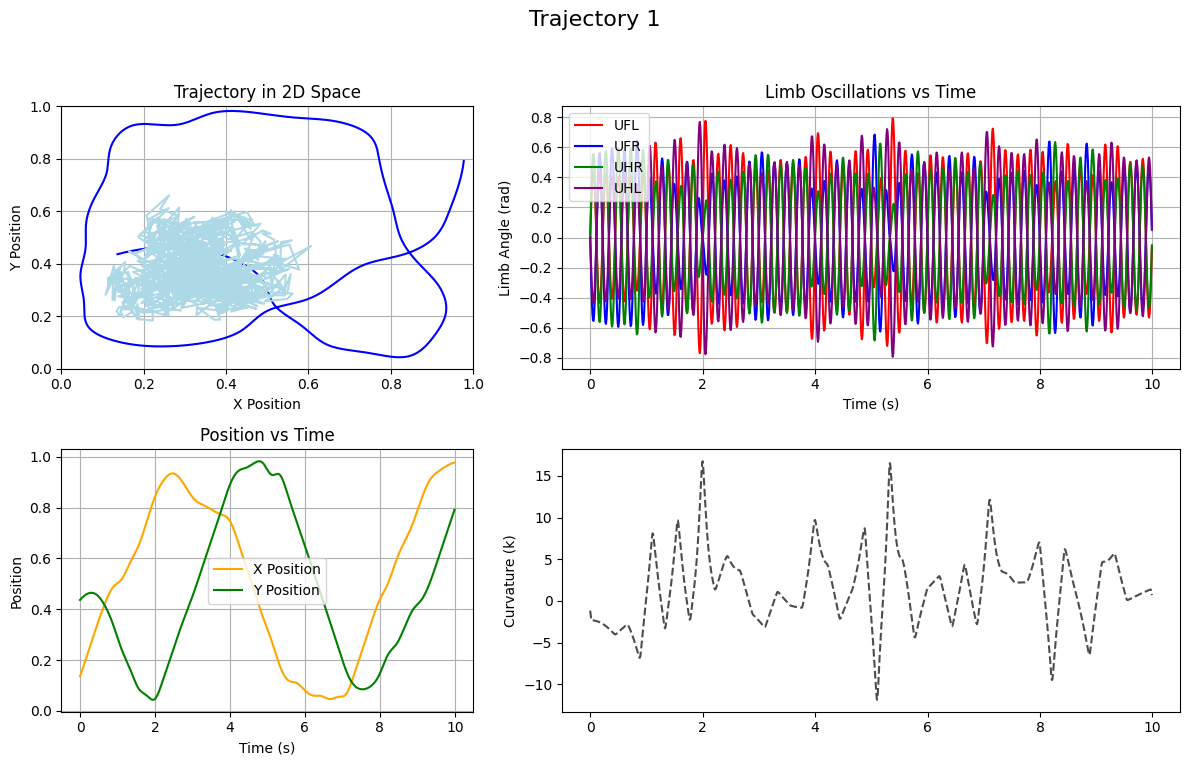

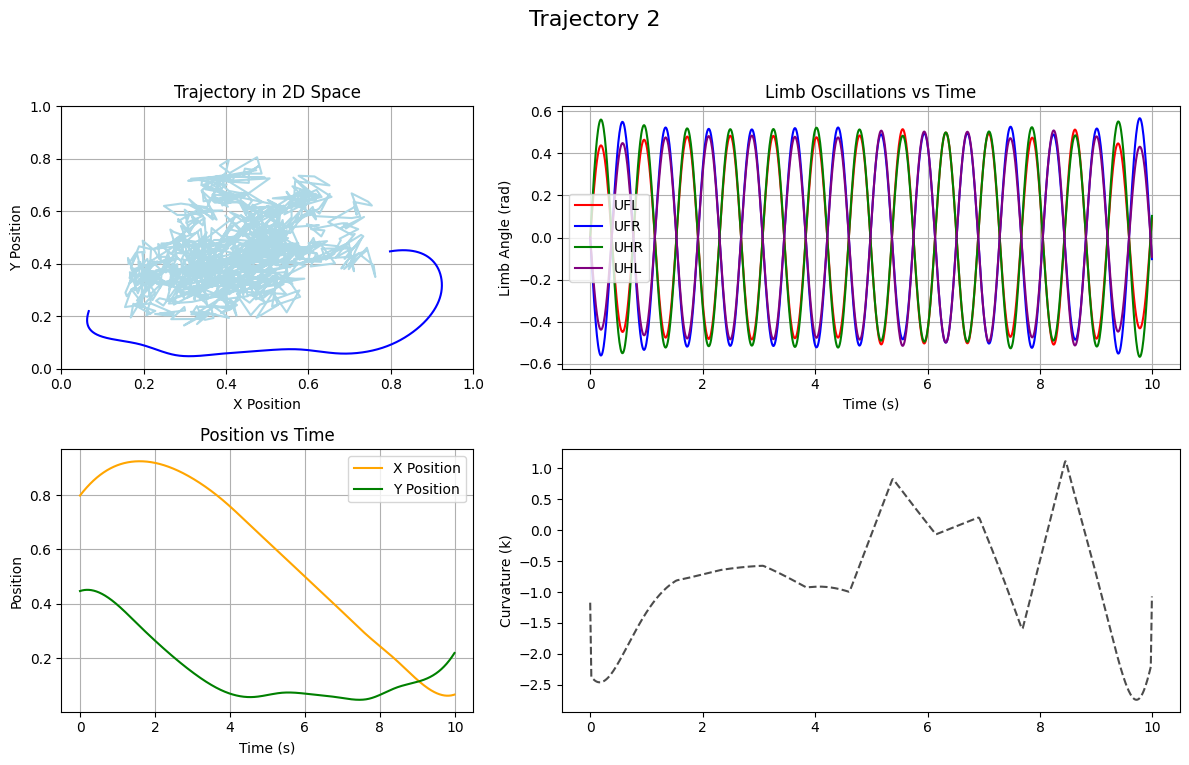

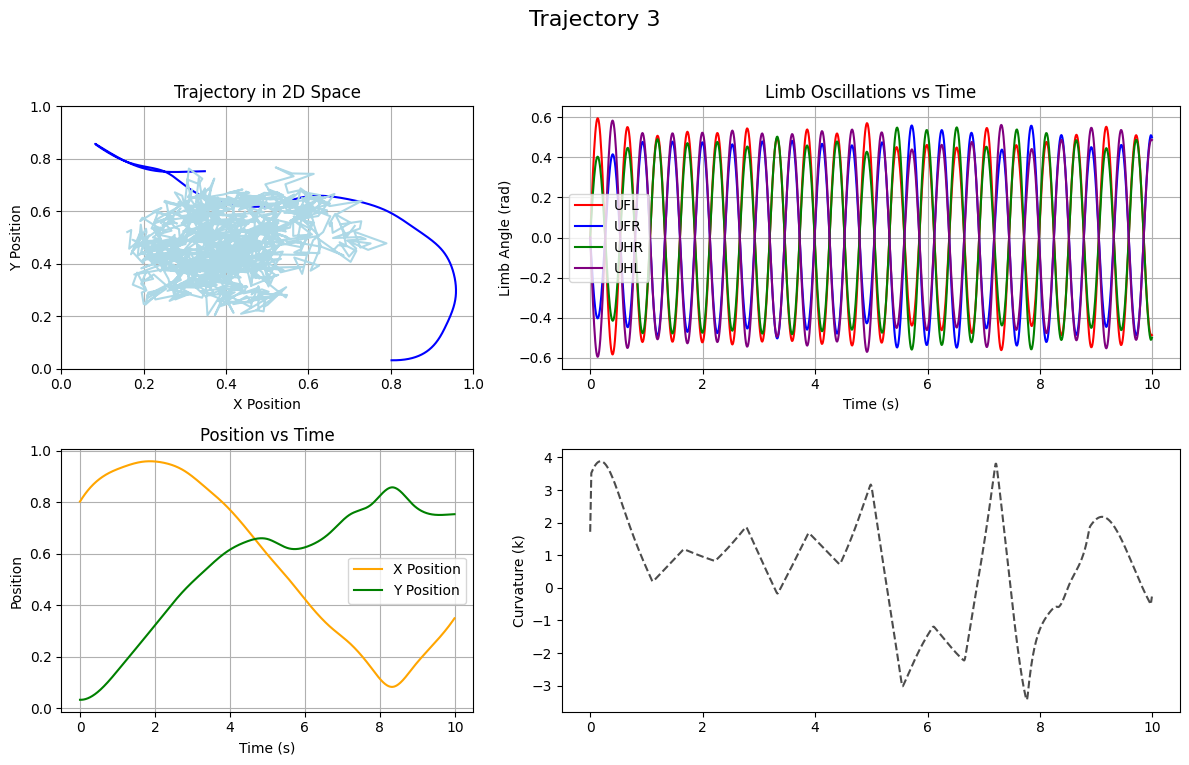

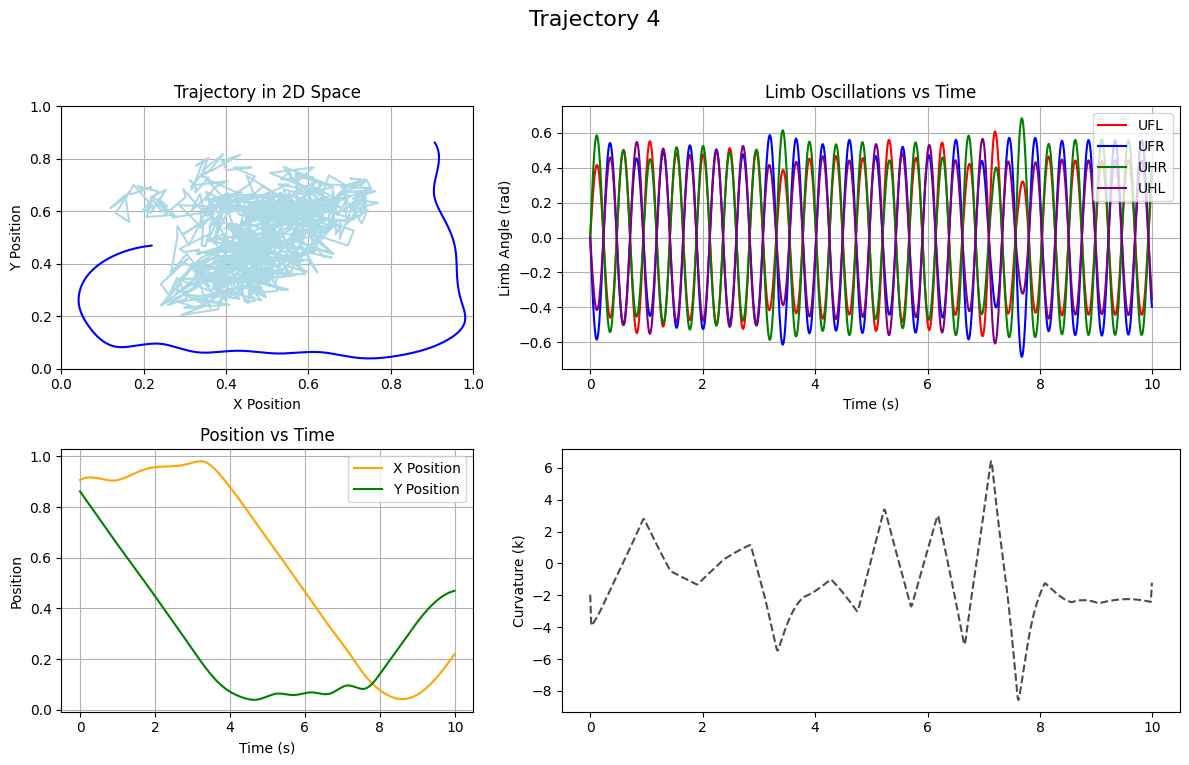

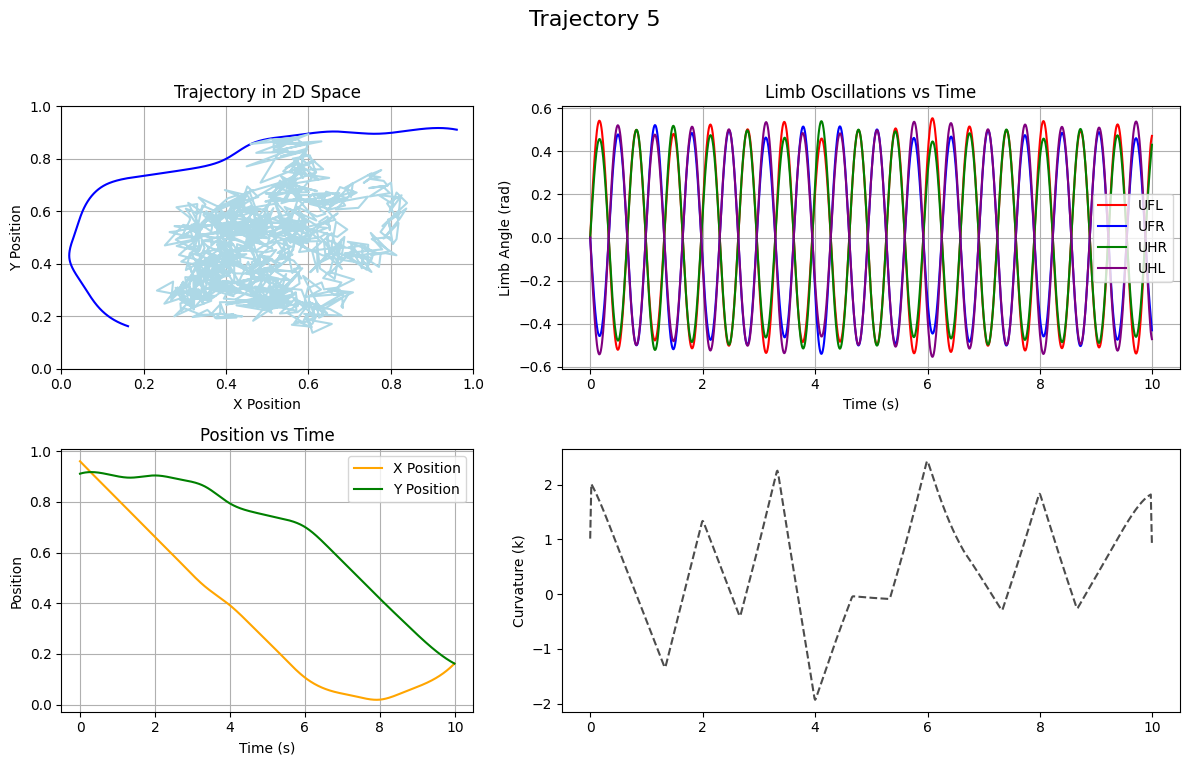

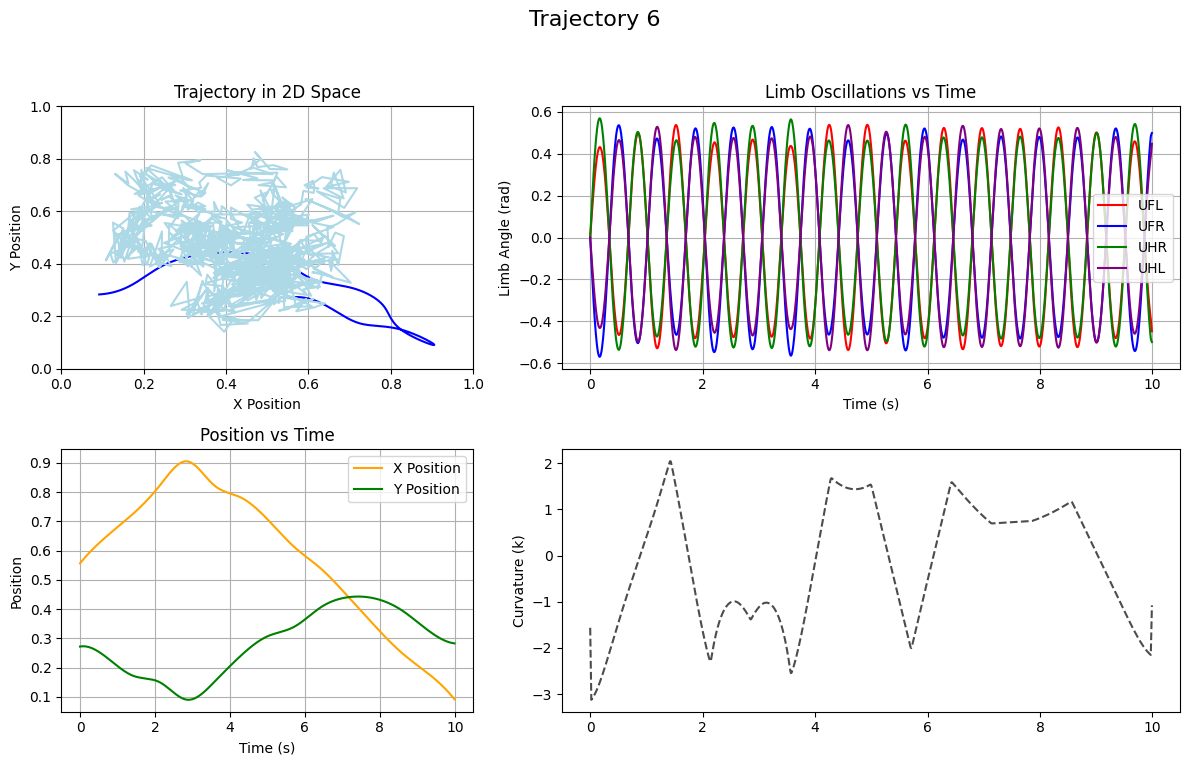

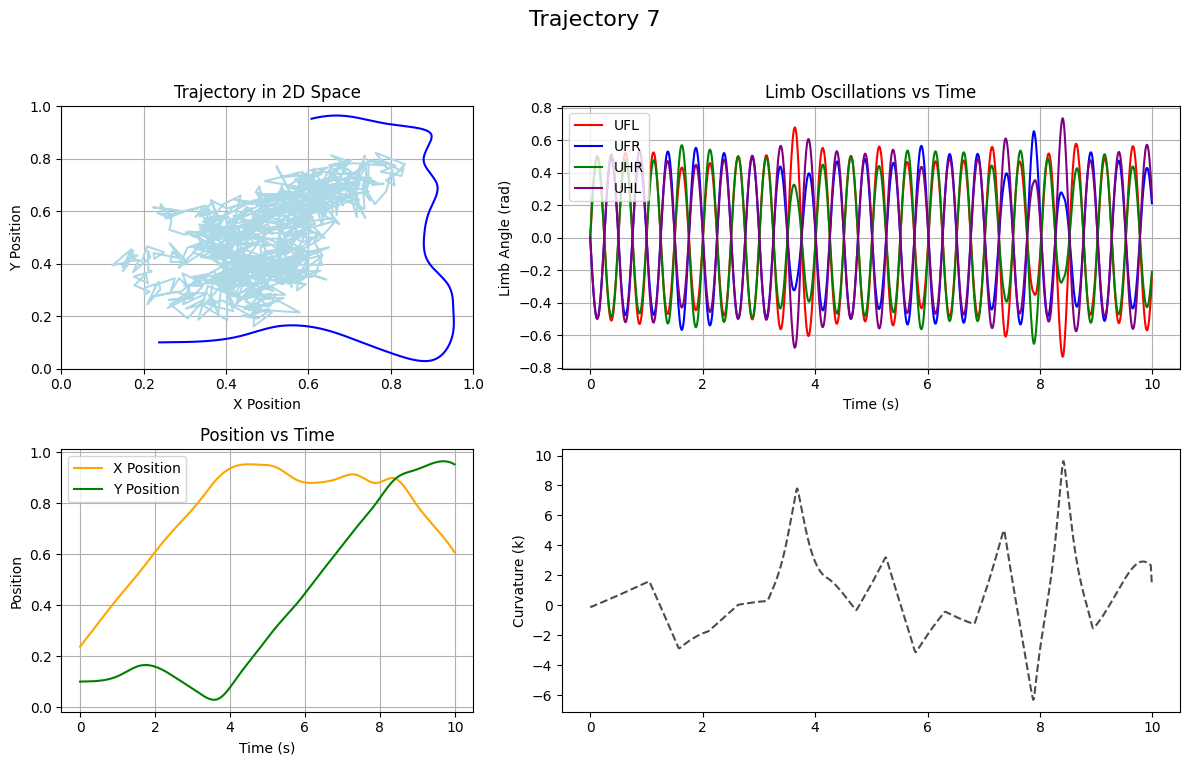

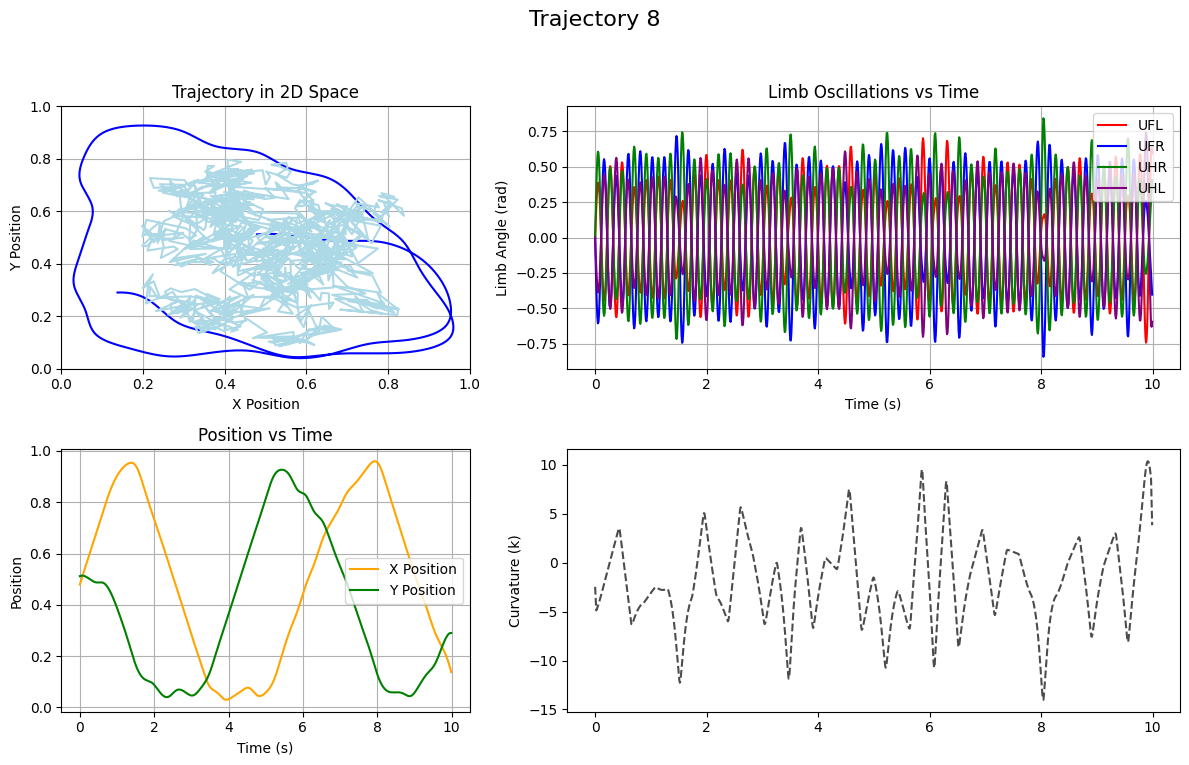

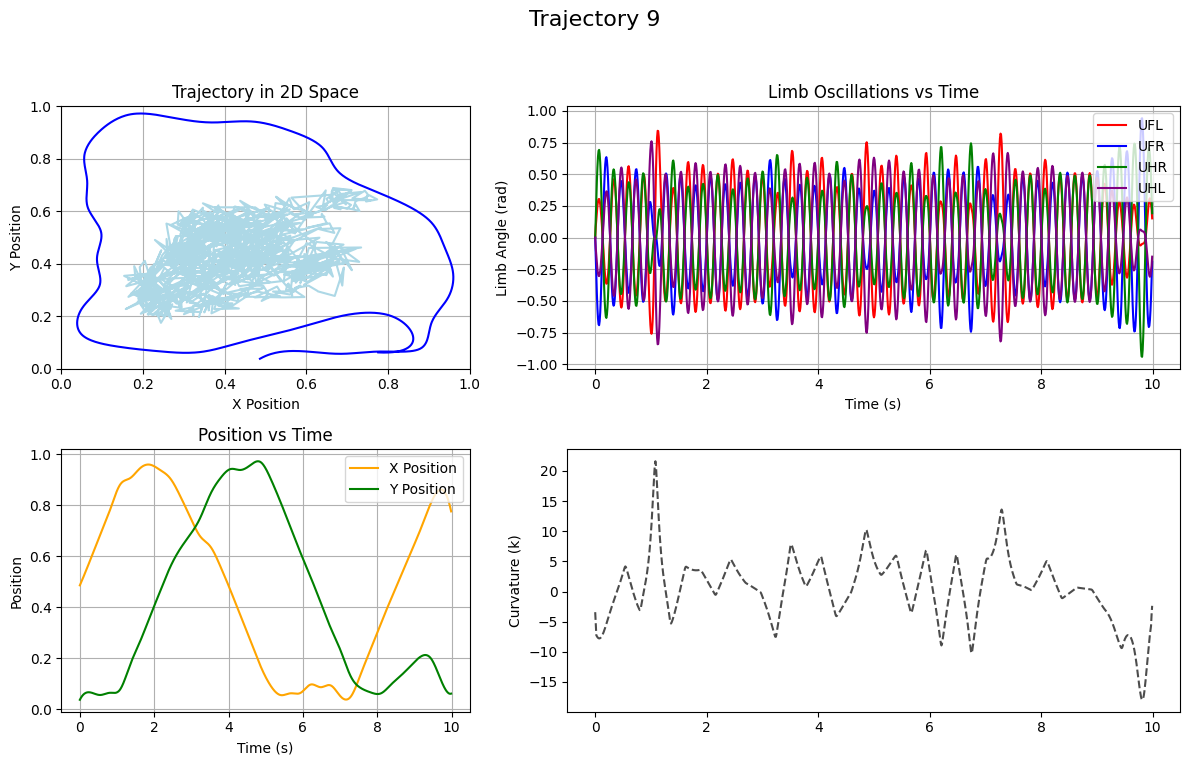

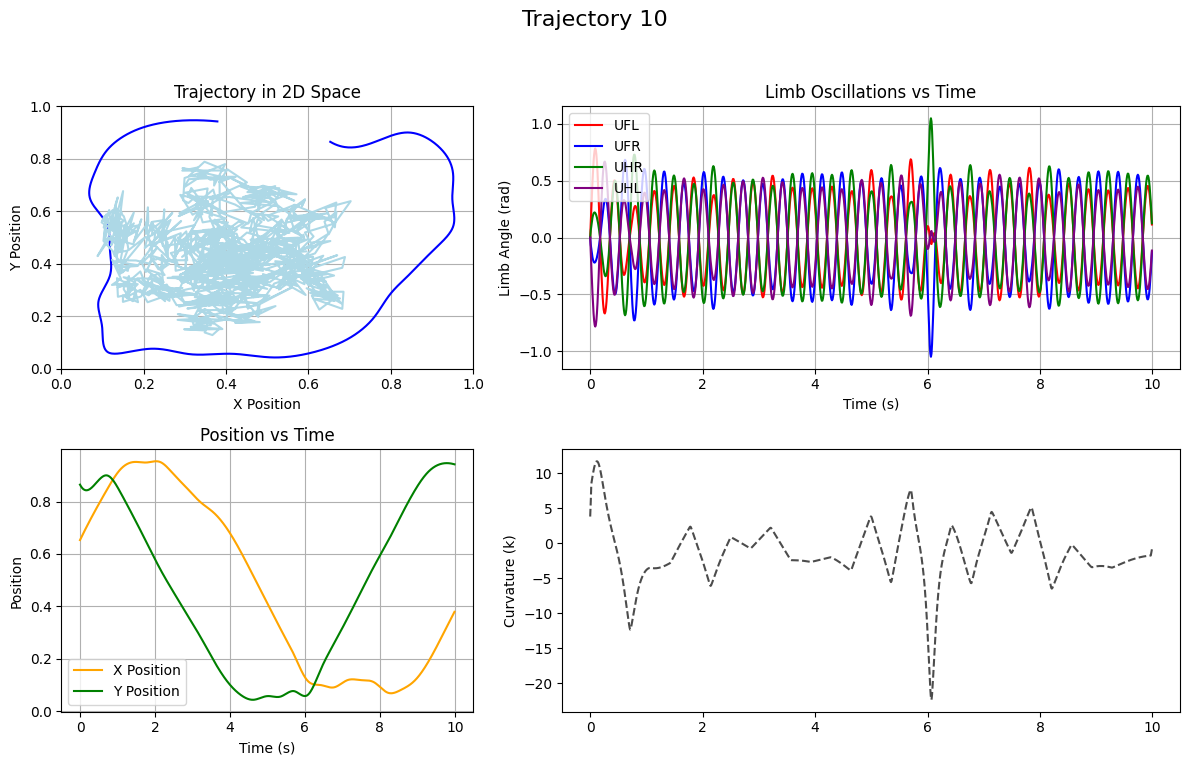

In [47]:
# Plotting trajectory, position vs time and limb oscillations for five random trajectories
for i in range(0, 10):

    #traj_index = np.random.randint(0, 100)
    traj_index = i
    X_traj = x_smooth_all[traj_index]
    Y_traj = y_smooth_all[traj_index]
    limb_data_traj = limb_data_all[traj_index]
    UFL, UFR, UHR, UHL, k = limb_data_traj

    # Time vector
    t = time_series[:len(X_traj)]

    # Create a 2x2 grid
    fig, axes = plt.subplots(2, 2, figsize=(12, 8), gridspec_kw={'width_ratios': [1, 1.5]})
    fig.suptitle(f"Trajectory {traj_index+1}", fontsize=16)

    # --- Top-left: Trajectory in grid ---
    axes[0, 0].plot(X_traj, Y_traj, color='blue')
    axes[0, 0].plot(pos_pred[traj_index, :, 0], pos_pred[traj_index, :, 1], color='lightblue')
    axes[0, 0].set_title('Trajectory in 2D Space')
    axes[0, 0].set_xlabel('X Position')
    axes[0, 0].set_ylabel('Y Position')
    axes[0, 0].set_xlim(0, 1)
    axes[0, 0].set_ylim(0, 1)
    axes[0, 0].grid()

    # --- Bottom-left: Position vs time ---
    axes[1, 0].plot(t, X_traj, label='X Position', color='orange')
    axes[1, 0].plot(t, Y_traj, label='Y Position', color='green')
    axes[1, 0].set_title('Position vs Time')
    axes[1, 0].set_xlabel('Time (s)')
    axes[1, 0].set_ylabel('Position')
    axes[1, 0].legend()
    axes[1, 0].grid()

    # --- Right column (span): Limb oscillations ---
    ax_right = axes[0, 1]
    #axes[1, 1].remove()  # merge bottom cell with top
    ax_right.plot(t, UFL[:len(t)], label='UFL', color='red')
    ax_right.plot(t, UFR[:len(t)], label='UFR', color='blue')
    ax_right.plot(t, UHR[:len(t)], label='UHR', color='green')
    ax_right.plot(t, UHL[:len(t)], label='UHL', color='purple')
    ax_right.set_title('Limb Oscillations vs Time')
    ax_right.set_xlabel('Time (s)')
    ax_right.set_ylabel('Limb Angle (rad)')
    ax_right.legend()
    ax_right.grid()

    #Plotting k values
    ax_bottom_right = axes[1, 1]
    
    ax_bottom_right.plot(t, k[:len(t)], label='Curvature (k)', color='black', linestyle='--', alpha=0.7)
    ax_bottom_right.set_ylabel('Curvature (k)')
    #ax_k.legend(loc='upper right')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
